In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=500, precision=1)

In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, axis=3)
x_train = (x_train - 127.5) / 127.5 # normalize value to [-1, 1]

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 2048
LATENT_DIM = 100

dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
# Define the discriminator
D = tf.keras.Sequential()
D.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                    input_shape=[28, 28, 1]))
D.add(layers.LeakyReLU(alpha=0.2))
D.add(layers.Dropout(0.3))

D.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
D.add(layers.LeakyReLU(alpha=0.2))
D.add(layers.Dropout(0.3))

D.add(layers.Flatten())
D.add(layers.Dense(1, activation='sigmoid'))

# Display the discriminator
D.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0

In [5]:
# Define the generator

G = tf.keras.Sequential()
G.add(layers.Dense(7*7*256, input_shape=(LATENT_DIM, )))
G.add(layers.BatchNormalization())
G.add(layers.ReLU())

G.add(layers.Reshape((7, 7, 256)))

G.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
G.add(layers.BatchNormalization())
G.add(layers.ReLU())

G.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
G.add(layers.BatchNormalization())
G.add(layers.ReLU())

G.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                             activation='tanh'))

G.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)       

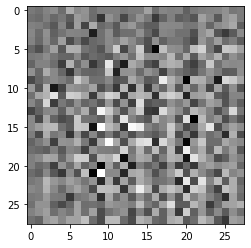

In [6]:
z = tf.random.normal([1, LATENT_DIM])
fake_img = G(z, training=False)
plt.imshow(fake_img[0, :, :, 0], cmap='gray')

In [7]:
# Define losses
cross_entropy = tf.keras.losses.BinaryCrossentropy()
binary_accuracy = tf.keras.metrics.BinaryAccuracy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(0.9*tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_acc = binary_accuracy(tf.ones_like(real_output), real_output)
    fake_acc = binary_accuracy(tf.ones_like(fake_output), fake_output)
    return (real_loss + fake_loss), (real_acc + fake_acc)/2

def generator_loss(fake_output):
    fake_loss = cross_entropy(0.9*tf.ones_like(fake_output), fake_output)
    return fake_loss


In [8]:
# Define optimizers
G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [9]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
        generated_imgs = G(noise, training=True)

        real_output = D(images, training=True)
        fake_output = D(generated_imgs, training=True)

        G_loss = generator_loss(fake_output)
        D_loss, D_acc = discriminator_loss(real_output, fake_output)
    G_gradients = G_tape.gradient(G_loss, G.trainable_variables)
    D_gradients = D_tape.gradient(D_loss, D.trainable_variables)
    G_optimizer.apply_gradients(zip(G_gradients, G.trainable_variables))
    D_optimizer.apply_gradients(zip(D_gradients, D.trainable_variables))
    return G_loss, D_loss, D_acc
    

In [ ]:
EPOCHS = 1000 

real = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    d_loss = g_loss = d_acc = 0.0
    n = 0
    for batch in dataset:
        dl, gl, da = train_step(batch)
        d_loss += dl
        d_acc += da
        g_loss += gl
        n += 1
    print("Epoch %d: d_loss %f, d_acc %f, g_loss %f" % (epoch+1, d_loss/n, d_acc/n, g_loss/n), end="\n")

Epoch 1: d_loss 0.636836, d_acc 0.943764, g_loss 1.205263
Epoch 2: d_loss 0.663691, d_acc 0.952258, g_loss 1.228194
Epoch 3: d_loss 0.721298, d_acc 0.836873, g_loss 1.212181
Epoch 4: d_loss 0.799039, d_acc 0.765086, g_loss 1.120354
Epoch 5: d_loss 1.138447, d_acc 0.709540, g_loss 0.866252
Epoch 6: d_loss 1.083287, d_acc 0.667863, g_loss 0.886505
Epoch 7: d_loss 1.094151, d_acc 0.634166, g_loss 0.931987
Epoch 8: d_loss 1.344186, d_acc 0.607775, g_loss 0.812458


In [ ]:
fake_img = G(z, training=False)
plt.imshow(fake_img[0, :, :, 0], cmap='gray')

In [ ]:
z1 = tf.random.normal([1, LATENT_DIM])
fake_img = G(z1, training=False)
plt.imshow(fake_img[0, :, :, 0], cmap='gray')

In [ ]:
z2 = tf.random.normal([1, LATENT_DIM])
fake_img = G(z2, training=False)
plt.imshow(fake_img[0, :, :, 0], cmap='gray')

In [ ]:
z3 = (z1+z2)/2
fake_img = G(z3, training=False)
plt.imshow(fake_img[0, :, :, 0], cmap='gray')

In [ ]:
# loaded_model = tf.keras.models.load_model('/content/gdrive/My Drive/dcgan_g')
z4 = tf.random.normal([1, LATENT_DIM])
fake_img = loaded_model(z4, training=False)
plt.imshow(fake_img[0, :, :, 0], cmap='gray')